In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv('hmeq.csv')

In [3]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Для начала давайте рассмотрим длю пропусков в каждой колонке:

In [4]:
df.isna().mean(axis=0)

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

При рассмотрении этих данных стоит учитывать тот факт, что все эти заявки - кредиты, уже одобренные прошлым алгоритмом. Из-за этого отличия в данных говорят скорее не об особенностях клиентов, а о предвзятостях существующей модели.

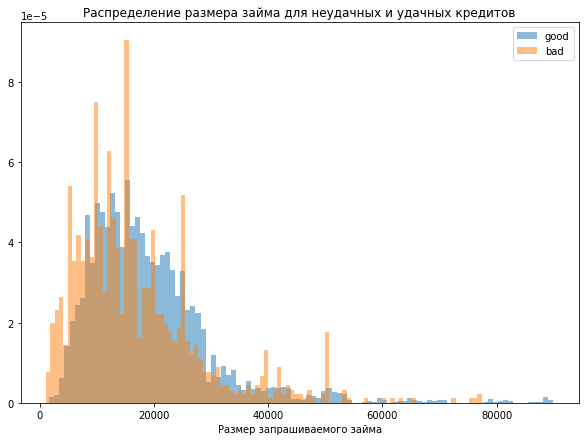

In [5]:
plt.figure(figsize=(10, 7))
plt.hist(df['LOAN'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['LOAN'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Размер запрашиваемого займа')
plt.title('Распределение размера займа для неудачных и удачных кредитов')
plt.show()

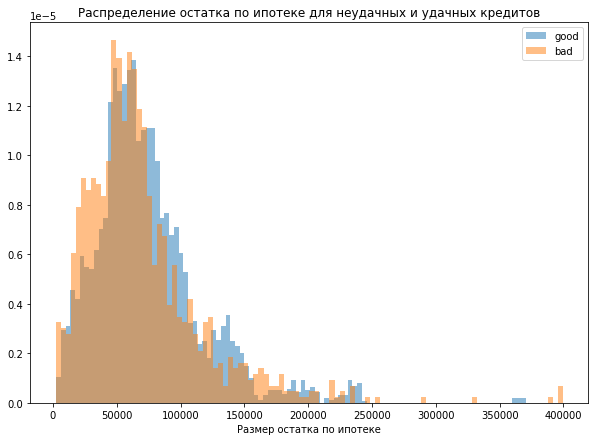

In [6]:
plt.figure(figsize=(10, 7))

plt.hist(df['MORTDUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['MORTDUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Размер остатка по ипотеке')
plt.title('Распределение остатка по ипотеке для неудачных и удачных кредитов')

plt.show()

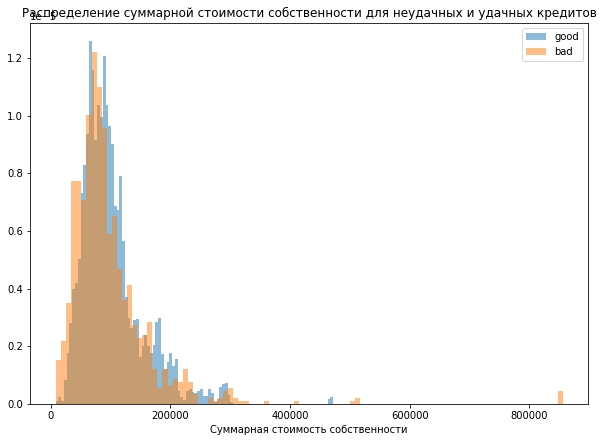

In [7]:
plt.figure(figsize=(10, 7))

plt.hist(df['VALUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['VALUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Суммарная стоимость собственности')
plt.title('Распределение суммарной стоимости собственности для неудачных и удачных кредитов')

plt.show()

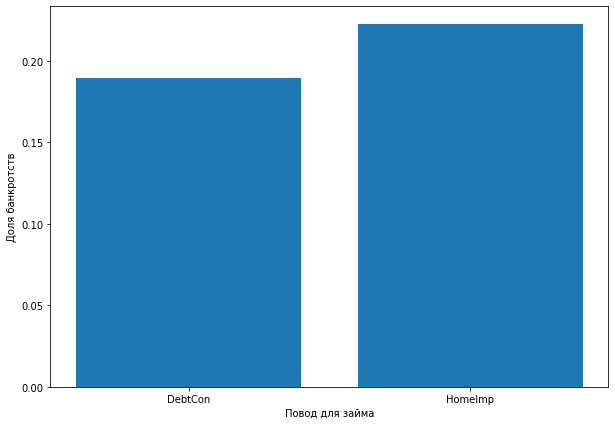

In [8]:
plt.figure(figsize=(10, 7))
plt.bar(x=['DebtCon', 'HomeImp'], height=(df.groupby('REASON').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Повод для займа')
plt.show()

Интуитивно понятно, что реструктуризация долгов - потенциально более рискованная инвестиция, чем покупка для улучшения дома. Возможно прошлые данные овер-компенсировали этот риск, поэтому в нашем датасете реструктуризация статистически надежнее.

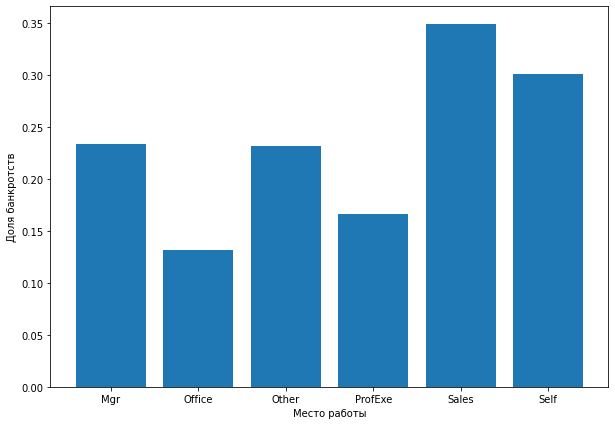

In [9]:
plt.figure(figsize=(10, 7))
plt.bar(x=(df.groupby('JOB').mean()['BAD']).index, height=(df.groupby('JOB').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Место работы')

plt.show()

Давайте оценим важность признаков с помощью t-статистики, чтобы выделить наиболее значимые для нашей классификации

In [10]:
dfpos = df[df['BAD'] == 0].drop(['BAD', 'JOB', 'REASON'] , axis=1)
dfneg = df[df['BAD'] == 1].drop(['BAD', 'JOB', 'REASON'] , axis=1)
t = np.abs(dfpos.mean(axis=0) - dfneg.mean(axis=0)) / np.sqrt((len(dfpos) * dfpos.std(axis=0)**2 + len(dfneg) * dfneg.std(axis=0)**2)/ (len(dfpos) + len(dfneg)))


In [11]:
t

LOAN       0.188425
MORTDUE    0.120885
VALUE      0.076650
YOJ        0.148999
DEROG      0.715846
DELINQ     0.944193
CLAGE      0.435324
NINQ       0.441615
CLNO       0.010427
DEBTINC    0.609487
dtype: float64

'DEROG', 'DELINQ' - обобщая, эти признаки говорят нам об уже просроченных кредитах. Понятно, почему эти признаки очень важны.

'DEBTINC' - отношение долга к доходу

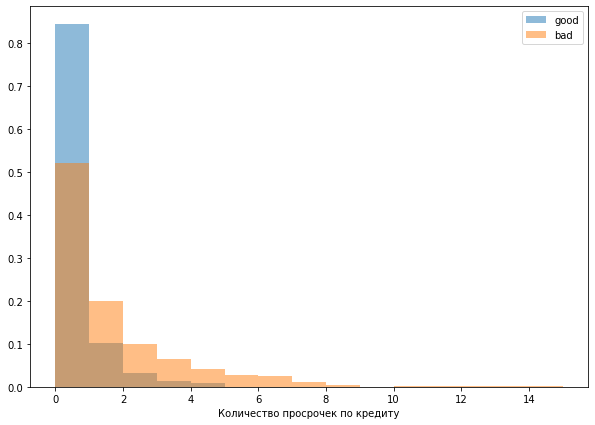

In [12]:
plt.figure(figsize=(10, 7))

plt.hist(df['DELINQ'][df['BAD'] == 0], bins=5, alpha=0.5, label='good', density=True)
plt.hist(df['DELINQ'][df['BAD'] == 1], bins=15, alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Количество просрочек по кредиту')

plt.show()

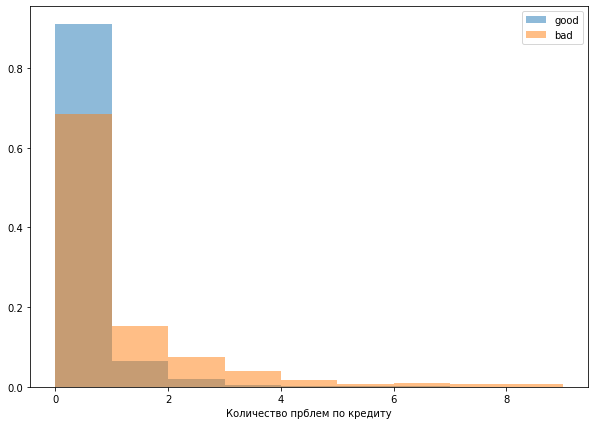

In [13]:
plt.figure(figsize=(10, 7))

plt.hist(df['DEROG'][df['BAD'] == 0], bins=range(10), alpha=0.5, label='good', density=True)
plt.hist(df['DEROG'][df['BAD'] == 1], bins=range(10), alpha=0.5, label='bad', density=True)
plt.legend()
plt.xlabel('Количество прблем по кредиту')

plt.show()

In [14]:
df['REASON'].value_counts()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [15]:
df['JOB'].value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [16]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

Давайте для начала заполним пропуски в категориальных переменных отдельным значением, в числовых - средним, а переменную с наибольшим количеством пропусков пока удалим.

In [17]:
import copy

In [18]:
df_pure = copy.deepcopy(df).drop('DEBTINC', axis=1)

In [19]:
df_pure[['JOB', 'REASON']] = df_pure[['JOB', 'REASON']].fillna('NAN')

In [20]:
df_pure = df_pure.fillna(df_pure.mean(axis=0))

In [21]:
y = df_pure['BAD'].values
X = df_pure.drop("BAD", axis=1).values

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
from sklearn.preprocessing import OneHotEncoder

Закодируем категориальные переменные

In [25]:
X = np.concatenate((X[:, :3], OneHotEncoder(sparse=False).fit_transform(X[:, [3, 4]]), X[:, 5:]), axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=179)


In [27]:
isnatrain, isnatest = train_test_split(df.isna().mean(axis=1), test_size=0.3, random_state=179)

In [28]:
mod = RandomForestClassifier(n_estimators=5000).fit(X_train, y_train)

In [29]:
print(mod.score(X_test, y_test))

0.9351230425055929


In [30]:
y_pred = mod.predict(X_test)

In [31]:
print(f"Positive train targets: {(y_train == 1).sum()}, negative train targets: {(y_train == 0).sum()}, ratio: {(y_train == 1).sum() / (y_train == 0).sum()}")
print(f"Positive test targets: {(y_test == 1).sum()}, negative test targets: {(y_test == 0).sum()}, ratio: {(y_test == 1).sum() / (y_test == 0).sum()}")
print(f"Positive predictions: {(y_pred == 1).sum()}, negative predictions: {(y_pred == 0).sum()}, ratio: {(y_pred == 1).sum() / (y_pred == 0).sum()}")

Positive train targets: 825, negative train targets: 3347, ratio: 0.2464893934867045
Positive test targets: 364, negative test targets: 1424, ratio: 0.2556179775280899
Positive predictions: 254, negative predictions: 1534, ratio: 0.16558018252933507


Accuracy - не самая удачная метрика, хотя баланс классов всего 4:1

In [32]:
from sklearn.metrics import accuracy_score
def kappa(y0, y1, pos=1, neg=0):
    po = accuracy_score(y0, y1)

    pos0 = (y0 == pos).mean()
    pos1 = (y1 == pos).mean()
    pe = (pos0 * pos1) + (1 - pos0) * (1 - pos1)

    k = (po - pe) / (1 - pe)
    return k

In [33]:
def matthews(pred, target, pos=1, neg=0):
    tp = np.sum((pred == pos) & (target == pos))
    tn = np.sum((pred == neg) & (target == neg))
    fp = np.sum((pred == pos) & (target == neg))
    fn = np.sum((pred == neg) & (target == pos))

    if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) == 0:
        return 0 # условность, чтобы не вылезало так много nan

    return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [35]:
print(f"Kappa value: {kappa(y_pred, y_test)}")
print(f"Matthews Correlation Coefficient: {matthews(y_pred, y_test)}")
print(f"ROC-AUC value: {roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1])}")
print(f"PR-AUC value: {auc(*reversed((precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1]))[:2]))}")


Kappa value: 0.774574163761097
Matthews Correlation Coefficient: 0.7929021598180407
ROC-AUC value: 0.9854794959254229
PR-AUC value: 0.960296604108566


In [36]:
print(f"Precision value: {precision_score(y_test, y_pred)}")
print(f"Recall value: {recall_score(y_test, y_pred)}")

Precision value: 0.9881889763779528
Recall value: 0.6895604395604396


Было бы логично предположить, что невозврат денег для нас несет больше урона, чем бы нам принесло успешное возвращение. Это говорит нам о том, что порог выдачи кредита стоит выставить ниже чем 0.5 вероятности дефолта

Напишем функцию, которая максимизирует ожидание прибыли, исходя из предположения о том, что наша выгода составляет x% суммы, и если человек не возвращает сумму, он не возвращает ее целиком

In [37]:
def get_prediction(mod, X_test, y_test, x=15):
    y_prob = mod.predict_proba(X_test)[:, 1]
    threshold = (x / 100) / (1 + x / 100)
    y_pred = y_prob > threshold
    return y_pred * 1.0

In [38]:
y_pred_finance = get_prediction(mod, X_test, y_test)

Введем метрику, которая оценивает лосс как упущенную выгоду, по сравнению с идеальным предсказанием.

In [39]:
def get_loss(y_pred, y_target, loan, x=15):
    return (((y_pred == 1) & (y_target == 0)) * loan * x / 100 +  ((y_pred == 0) & (y_target == 1)) * loan).sum()

In [40]:
get_loss(y_pred_finance, y_test, X_test[:, 0])

620495.0

In [41]:
get_loss(y_test, y_test, X_test[:, 0])

0.0

Если выдавать кредит по предсказанию модели:

In [42]:
get_loss(y_pred, y_test, X_test[:, 0])

2098365.0

Давайте проведем те же манипуляции, но с использованием SMOTE для апсемплинга минорного класса.

In [43]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [44]:
def print_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    print(f"Kappa value: {kappa(y_pred, y_test)}")
    print(f"Matthews Correlation Coefficient: {matthews(y_pred, y_test)}")
    print(f"ROC-AUC value: {roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1])}")
    print(f"PR-AUC value: {auc(*reversed((precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1]))[:2]))}")
    print(f"Precision value: {precision_score(y_test, y_pred)}")
    print(f"Recall value: {recall_score(y_test, y_pred)}")
    y_pred_finance = get_prediction(mod, X_test, y_test)
    print(f"Loss: {get_loss(y_pred_finance, y_test, X_test[:, 0])}")

In [45]:
X_train_new, y_train_new = SMOTE(sampling_strategy=1/2).fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [46]:
mod2 = RandomForestClassifier(n_estimators=5000).fit(X_train_new, y_train_new)

In [47]:
print(mod2.score(X_test, y_test))

0.9407158836689038


Новые значения:

In [48]:
print_metrics(mod2, X_test, y_test)

Kappa value: 0.7977358297261994
Matthews Correlation Coefficient: 0.8108865015414041
ROC-AUC value: 0.9861614859859242
PR-AUC value: 0.9608193738103792
Precision value: 0.9777777777777777
Recall value: 0.7252747252747253
Loss: 714755.0


Старые значения:

In [49]:
print_metrics(mod, X_test, y_test)

Kappa value: 0.774574163761097
Matthews Correlation Coefficient: 0.7929021598180407
ROC-AUC value: 0.9854794959254229
PR-AUC value: 0.960296604108566
Precision value: 0.9881889763779528
Recall value: 0.6895604395604396
Loss: 620495.0


Забавно, все метрики улучшены, а денег мы теряем больше.

Так как теперь мы активно используем вероятности, предсказанные моделью для нашей калибровки, встает вопрос, насколько эффективно выдача нашей модели оценивает реальную вероятность того, что человек вернет кредит. Построим calibration curve, чтобы оценить качество оценки вероятностей нашей моделью.

In [50]:
def build_calibration_curve(mod, X, y):
    probs = mod.predict_proba(X)[:, 1]
    vals = []
    for prob in np.arange(0, 1, 0.05):
        vals.append(y[(probs >= prob) & (probs < prob + 0.05)].mean())
    plt.plot(np.arange(0, 1, 0.05) + 0.025, vals, label='Our curve')
    plt.plot(np.arange(0, 1, 0.05) + 0.025, np.arange(0, 1, 0.05) + 0.025, label='Perfect curve')
    return vals

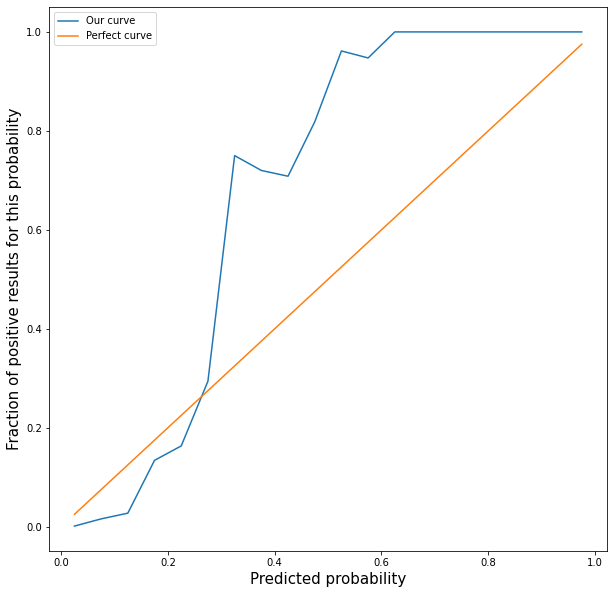

In [51]:
plt.figure(figsize=(10, 10))
vals = build_calibration_curve(mod, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

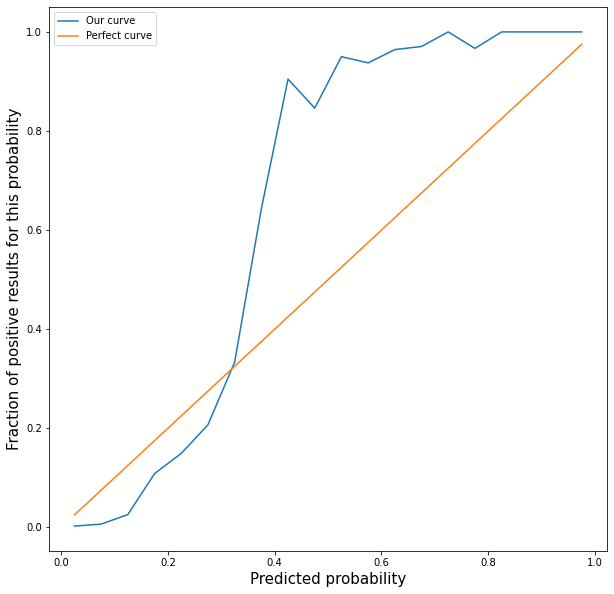

In [52]:
plt.figure(figsize=(10, 10))
vals2 = build_calibration_curve(mod2, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

Как видно, обе наши модели не очень хорошо передают настоящее распределение вероятностей. Такую "S-образную" форму кривой можно объяснить [$^1$](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf) высокой вариативностью каждого из деревьев используемых в RandomForest, в результате чего получить среднее предзсказание деревьев ровно в 0 почти невозможно, так как тогда все деревья должны были бы выдать одно и то же нулевое предсказание, что маловероятно.

In [53]:
from sklearn.calibration import CalibratedClassifierCV

In [54]:
cal_sig_mod = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000)).fit(X_train, y_train)

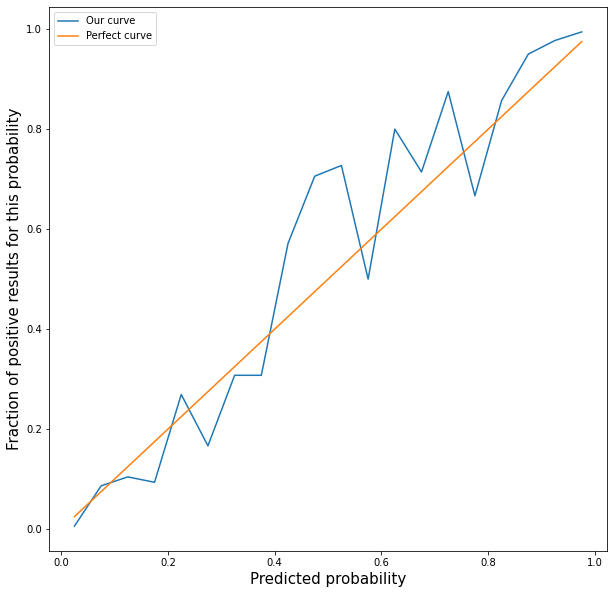

In [55]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_sig_mod, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [56]:
print_metrics(cal_sig_mod, X_test, y_test)

Kappa value: 0.850581748911612
Matthews Correlation Coefficient: 0.8529081456962989
ROC-AUC value: 0.981542860229658
PR-AUC value: 0.9526448681523616
Precision value: 0.934984520123839
Recall value: 0.8296703296703297
Loss: 685050.0


Мы немного увеличили метрики качества классификации, но немного уменьшили нашу целевую метрику - выгоду

In [57]:
cal_iso_mod = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000), method='isotonic').fit(X_train, y_train)

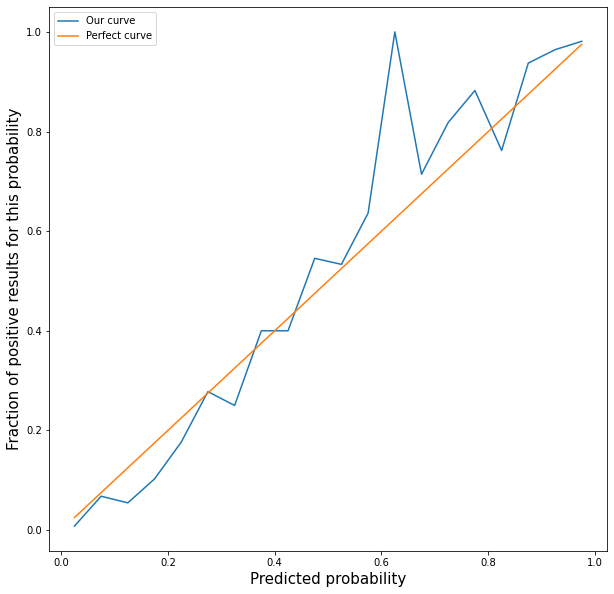

In [58]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_iso_mod, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [59]:
print_metrics(cal_iso_mod, X_test, y_test)

Kappa value: 0.8521595677278214
Matthews Correlation Coefficient: 0.8534616519725069
ROC-AUC value: 0.9807682661439683
PR-AUC value: 0.9515476637678484
Precision value: 0.9219219219219219
Recall value: 0.8434065934065934
Loss: 640400.0


Возможно оверсемплинг выборки вместе с калибровкой вероятностью помогут нам улучшить качество? 

In [60]:
cal_sig_mod2 = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000)).fit(X_train_new, y_train_new)

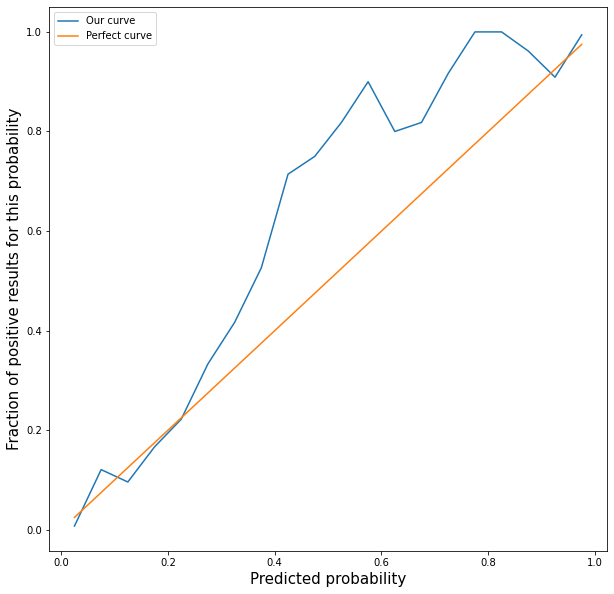

In [61]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_sig_mod2, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [62]:
print_metrics(cal_sig_mod2, X_test, y_test)

Kappa value: 0.8496542219378337
Matthews Correlation Coefficient: 0.8544995777450863
ROC-AUC value: 0.981091415606865
PR-AUC value: 0.9497509146854949
Precision value: 0.9607843137254902
Recall value: 0.8076923076923077
Loss: 690375.0


In [63]:
cal_iso_mod2 = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000), method='isotonic').fit(X_train_new, y_train_new)

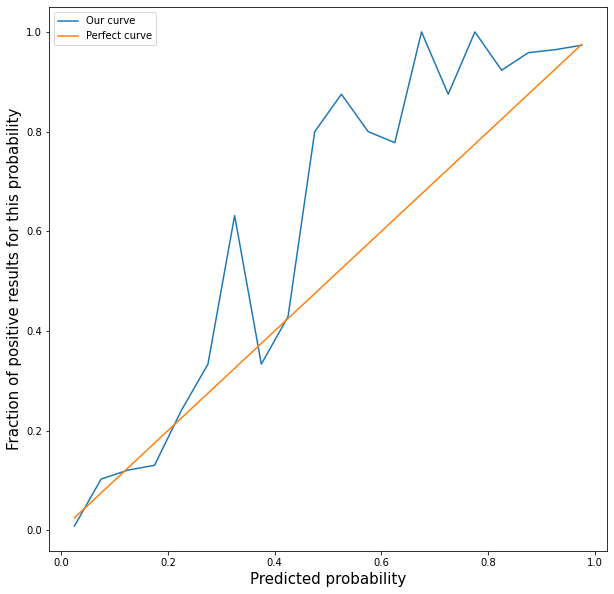

In [64]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_iso_mod2, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [65]:
print_metrics(cal_iso_mod2, X_test, y_test)

Kappa value: 0.8536393700271765
Matthews Correlation Coefficient: 0.8581550644962974
ROC-AUC value: 0.9801865971107544
PR-AUC value: 0.9470570354340664
Precision value: 0.961038961038961
Recall value: 0.8131868131868132
Loss: 696390.0


Улучшение точности предсказания вероятности существующими методами не приводит к улучшению нашей существующей модели, но возможно улучшит результат для наших следующих попыток.

Попробуем усреднить предсказания с и без калибровки, это часто улучшает результат

In [75]:
def get_prediction2(y_prob, X_test, y_test, x=15):
    threshold = (x / 100) / (1 + x / 100)
    y_pred = y_prob > threshold
    return y_pred * 1.0

In [76]:
def print_metrics2(mod1, mod2, X_test, y_test):
    y_pred1 = mod1.predict_proba(X_test)[:, 1]
    y_pred2 = mod2.predict_proba(X_test)[:, 1]
    y_predp = ((y_pred1 + y_pred2) / 2)
    y_pred = np.round(y_predp)
    print(f"Kappa value: {kappa(y_pred, y_test)}")
    print(f"Matthews Correlation Coefficient: {matthews(y_pred, y_test)}")
    print(f"ROC-AUC value: {roc_auc_score(y_test, y_predp)}")
    print(f"PR-AUC value: {auc(*reversed((precision_recall_curve(y_test, y_predp))[:2]))}")
    print(f"Precision value: {precision_score(y_test, y_pred)}")
    print(f"Recall value: {recall_score(y_test, y_pred)}")
    y_pred_finance = get_prediction2(y_predp, X_test, y_test)
    print(f"Loss: {get_loss(y_pred_finance, y_test, X_test[:, 0])}")

In [77]:
print_metrics2(mod, cal_iso_mod2, X_test, y_test)

Kappa value: 0.8389109120055673
Matthews Correlation Coefficient: 0.8454418837139523
ROC-AUC value: 0.9839332016298309
PR-AUC value: 0.9569434407665567
Precision value: 0.9663299663299664
Recall value: 0.7884615384615384
Loss: 610045.0


Наблюдается небольшое улучшение